In [1]:
import numpy as np
import pandas as pd
# pd.set_option('mode.chained_assignment', 'raise')
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')
# %matplotlib inline

import seaborn as sns

# Suppress warning about mixed data types in columns (change this later?)
import warnings
# warnings.filterwarnings('ignore')

# Import Some of the useful defined functions
import useful_fun as uf
# object with different useful regions defined
regions = uf.Regions()

In [2]:
# Reading the dataframe
lits_2016_full = pd.read_csv('./data/LiTS_III_2016.csv') # data in the repo folder linux
# lits_2016 = pd.read_csv('LiTS III.csv')

In [3]:
# Find all the columns that are question columns
all_question_col = list(uf.findColumn('q',lits_2016_full));
np.shape(all_question_col)

(565,)

In [4]:
# Dataframe with only the question columns and necessary columns
lits_2016_questions_only = lits_2016_full[all_question_col];

In [5]:
# Check for null values
checkNull = lits_2016_questions_only.isnull().sum().sort_values(ascending=False)

In [6]:
# Drop the columns that have more than 1000 null values
columns_with_few_nulls = list(checkNull[checkNull<1000].index)
np.shape(columns_with_few_nulls)


(234,)

In [7]:
# What are definitely neccessary columns?
needed_col =[
    'country',#     'Country',
    'q412',#        'Political System',
    'q411',#        'Economy Type',
]

In [8]:
for col in needed_col:
    try:
        columns_with_few_nulls.index(col)
    except:
        columns_with_few_nulls.append(col)

np.shape(columns_with_few_nulls)

(235,)

In [9]:
# Select the columns that are left over and drop the values that are nan
lits_2016_selected = lits_2016_full[columns_with_few_nulls];
lits_2016_selected = lits_2016_selected.dropna()
lits_2016_selected.shape


(47684, 235)

In [10]:
# remove columns with only 1 unique value
rem_cols = [];
for column in lits_2016_selected:
    nr_values= len(np.unique(lits_2016_selected[column]))
    if nr_values == 1:
        print('{} col has No {} of values'.format(column, nr_values))
        rem_cols.append(column)
        

q413_97 col has No 1 of values
q413_96 col has No 1 of values
q102_1 col has No 1 of values
q217b col has No 1 of values


In [11]:
lits_2016_selected = lits_2016_selected.drop(rem_cols,axis=1)
lits_2016_selected.shape

(47684, 231)

In [12]:
# remove greece questions
rem_cols = [
    'q1008_other',
    'q1009_other',
    'q1010_other',
    'q1012_other'
]

lits_2016_selected = lits_2016_selected.drop(rem_cols,axis=1)
lits_2016_selected.shape

(47684, 227)

In [13]:
# Others that I don't think can be turned into features
rem_cols = [
    'q105_1',              # - age
    'q927',                # - height
    'q906b',               # - place
    'q911b',               # - place
    'q914b',               # - place
    'q923_ethnicity',      # - too many       
    'q902',                # - weight
    'q909b',               # - placed moved from
    'q910b',               # - place of origin
    'q907b',               # - place
]

lits_2016_selected = lits_2016_selected.drop(rem_cols,axis=1)
lits_2016_selected.shape

(47684, 217)

In [14]:
# For the binary features try and use categorical features with less than 14 categories (might need to change that to less)

features = []
potential_bin_features = 0
for column in lits_2016_selected:
    nr_values= len(np.unique(lits_2016_selected[column]))
    if nr_values <= 14:
        potential_bin_features = potential_bin_features+nr_values;
        features.append(column)

lits_2016_selected = lits_2016_selected[features]
# Also set all the datatypes as int !!!!!!!!!!!!!!!!!!!!!!!!
lits_2016_selected = lits_2016_selected.astype(int)
lits_2016_selected.shape

(47684, 203)

In [15]:
# Create a dataframe with binary features from the existing categorical features.

lits_2016_selected_dummies = pd.get_dummies(lits_2016_selected, columns = features,prefix_sep='_')

# Keep the 'POLITICAL SYSTEM CLASSES'
class_col= 'Political System'
lits_2016_selected_dummies[class_col] = lits_2016_selected['q412']

# Remove the political system as binary feature
rem_cols = list(uf.findColumn('q412',lits_2016_selected_dummies))
lits_2016_selected_dummies = lits_2016_selected_dummies.drop(rem_cols,axis=1)


# Check that the last column is Political System.
# list(lits_2016_selected_dummies.columns)[-1:]
lits_2016_selected_dummies.shape

(47684, 1068)

In [16]:

# Set different catergorical classes to strings to make it clearer
replace = {'Political System':{
 1: 'democratic',
 2: 'authoritarian',
 3: 'indifferent',
 -97 : 'dont know'},
 }
lits_2016_selected_dummies = lits_2016_selected_dummies.replace(replace);
np.unique(lits_2016_selected_dummies[class_col])

array(['authoritarian', 'democratic', 'dont know', 'indifferent'],
      dtype=object)

In [17]:
# col_count = [
# 'dem_true',    # 1 - democratic - True
# 'auth_true',    # 2 - authoritarian - True
# 'ind_true',    # 3 - indifferent - True
# 'dk_true',    # -97 - don't know - True
# 'dem_false',    # 1 - democratic - False
# 'auth_false',    # 2 - authoritarian - False
# 'ind_false',    # 3 - indifferent - False
# 'dk_false',    # -97 - don't know - False
# ]
col_count = np.unique(lits_2016_selected_dummies[class_col])

df_counts = pd.DataFrame(index=lits_2016_selected_dummies.iloc[:,:-1].columns,columns=col_count)
df_counts.shape

(1067, 4)

In [18]:
# !!!!!!!!!!!!11 put this in couple of for loops


# for index in df_counts.index:
#     ser = lits_2016_selected_dummies.value_counts([index,'Political System'],normalize=True)
#     try:
#         df_counts.loc[index,'dem_true',] = ser[1][1]
#         df_counts.loc[index,'auth_true',] = ser[1][2]
#         df_counts.loc[index,'ind_true',] = ser[1][3]
#         df_counts.loc[index,'dk_true',] = ser[1][-97]
#         df_counts.loc[index,'dem_false',] = ser[0][1]
#         df_counts.loc[index,'auth_false',] = ser[0][2]
#         df_counts.loc[index,'ind_false',] = ser[0][3]
#         df_counts.loc[index,'dk_false',] = ser[0][-97]
#     except:
#         print(index)
#         print(ser)



df_counts_normalized = df_counts.copy() # Create a copy where you'll store the normalized count values

for index in df_counts.index:
    ser = lits_2016_selected_dummies.value_counts([index,'Political System'])
    ser_normalized = lits_2016_selected_dummies.value_counts([index,'Political System'],normalize=True)
    for col in df_counts.columns:
        try:
            df_counts.loc[index,col] = ser[1][col]
            df_counts_normalized.loc[index,col] = ser_normalized[1][col]
        except:
            df_counts.loc[index,col] = 0
            df_counts_normalized.loc[index,col] = 0




In [19]:
df_counts.head()

,authoritarian,democratic,dont know,indifferent
q218b_-97,5,18,13,7
q218b_1,163,482,90,232
q218b_2,442,1341,251,541
q218b_3,827,2257,464,1008
q218b_4,5446,15643,2658,6828


In [20]:
df_counts_normalized.head()

,authoritarian,democratic,dont know,indifferent
q218b_-97,0.000105,0.000377,0.000273,0.000147
q218b_1,0.003418,0.010108,0.001887,0.004865
q218b_2,0.009269,0.028123,0.005264,0.011346
q218b_3,0.017343,0.047332,0.009731,0.021139
q218b_4,0.11421,0.328056,0.055742,0.143193


In [21]:
 df_counts_normalized_columns = df_counts.apply(lambda x: x/x.max(), axis=0)

In [22]:
# df_counts_norm.head(20)
df_final = df_counts_normalized_columns * df_counts_normalized
df_final.head()

,authoritarian,democratic,dont know,indifferent
q218b_-97,0.0,0.0,0.000001,0.0
q218b_1,0.000065,0.000199,0.000042,0.000106
q218b_2,0.000477,0.001542,0.000329,0.000578
q218b_3,0.00167,0.004368,0.001123,0.002008
q218b_4,0.072417,0.209803,0.036856,0.092125


In [23]:
# for col in df_final.columns:
#     series = df_final.loc[:,col].sort_values(ascending = False).head(10)
#     print('\n!!!!!!! {}'.format(col))
#     print(series)
#     print('\n!!!!!!! \n\n')

In [24]:
feature_set = set()
for col in df_final.columns:
    feature_set.update(df_final.loc[:,col].sort_values(ascending = False).head(50).index)
final_features = list(feature_set)
final_features.append(class_col)

## Let's try and use the selected features for classification

In [25]:
nearest_neighb = 7

Training set:	 33379 examples
Valid set:	 4768 examples
Test set:	 9537 examples


democratic       0.513437
indifferent      0.221846
authoritarian    0.179484
dont know        0.085233
Name: Political System, dtype: float64

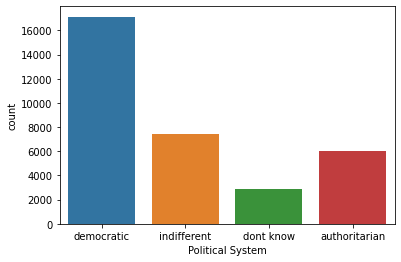

In [26]:
selected_df = lits_2016_selected_dummies[final_features].copy()

train, test, valid = uf.train_test_valid(selected_df)

sns.countplot(train[class_col]);
train[class_col].value_counts(normalize=True)

In [27]:
# Copy original split into new dataframes to not mix up guess outputs
train_not_balanced = train.copy()
test_not_balanced = test.copy()


#  Run the classifier on all the test values from the balanced training dataset
test_not_balanced['Guesses'] = test_not_balanced.apply(uf.predict_nn,args=(train_not_balanced, nearest_neighb, class_col), axis = 1)

# Check for accuracy
uf.calculate_accuracy(test_not_balanced,class_col)

authoritarian - 31.94%:
democratic - 61.45%:
dont know - 58.59%:
indifferent - 59.33%:

Total Accuracy - 58.39%:


### Reasonalbe results, let's try and balance the training set and see what result that gives

democratic       2845
dont know        2845
authoritarian    2845
indifferent      2845
Name: Political System, dtype: int64

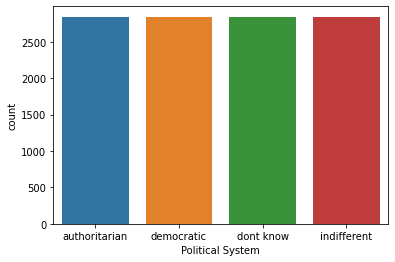

In [34]:
# Copy original split into new dataframes to not mix up guess outputs
train_balanced_not_boot = train.copy()
test_balanced_not_boot = test.copy()

# Balance the training dataset, by equaling the dataset size to the smallest size of the claseses.
train_balanced_not_boot = uf.balance_df(train_balanced_not_boot,class_col)


sns.countplot(train_balanced_not_boot[class_col]);
train_balanced_not_boot[class_col].value_counts()

In [33]:
#  Run the classifier on all the test values from the balanced training dataset
test_balanced_not_boot['Guesses'] = test_balanced_not_boot.apply(uf.predict_nn,args=(train_balanced_not_boot, nearest_neighb, class_col), axis = 1)

# Check for accuracy
uf.calculate_accuracy(test_balanced_not_boot,class_col)

authoritarian - 26.78%:
democratic - 67.03%:
dont know - 38.92%:
indifferent - 53.73%:

Total Accuracy - 48.21%:
